In [1]:
import numpy as np
import pandas as pd
from skillmodels.config import TEST_DIR
import yaml
from skillmodels.visualize_factor_distributions import (
    plot_factor_distributions,
)
from skillmodels.likelihood_function import get_maximization_inputs
from skillmodels.simulate_data import simulate_dataset

# How to visualize the distribution of latent factors

We show how to create Kernel density plots for pairs of latent factors in two or three dimensions. As illustration we use the same example as in the [introductory tutorial](../getting_started/tutorial.ipynb). For more details of how to obtain the filtered states, also see that tutorial.

There are two kinds of data that can be visualized with the function described below:
1. Filtered states, i.e. the estimates of the latent factors in an empirical dataset
2. Simulated states, i.e. a synthetic dataset of latent factors that is generated for a parametrized model. 

Below, we show how to get both kinds of datasets, how to visualize the distribution of latent factors given one dataset and how to visualize the difference in distributions between two datasets.

## Getting filtered states 

In [2]:
with open(TEST_DIR/"model2.yaml") as y:
        model_dict = yaml.load(y, Loader=yaml.FullLoader)

params = pd.read_csv(TEST_DIR / "regression_vault" / f"one_stage_anchoring.csv")
params = params.set_index(["category", "period", "name1", "name2"])

data = pd.read_stata(TEST_DIR / "model2_simulated_data.dta")
data.set_index(["caseid", "period"], inplace=True)

In [3]:
max_inputs = get_maximization_inputs(model_dict, data)
debug_loglike = max_inputs["debug_loglike"]
debug_data = debug_loglike(params)
filtered_states = debug_data["filtered_states"]
state_ranges = debug_data["state_ranges"]


## Plotting one dataset of states

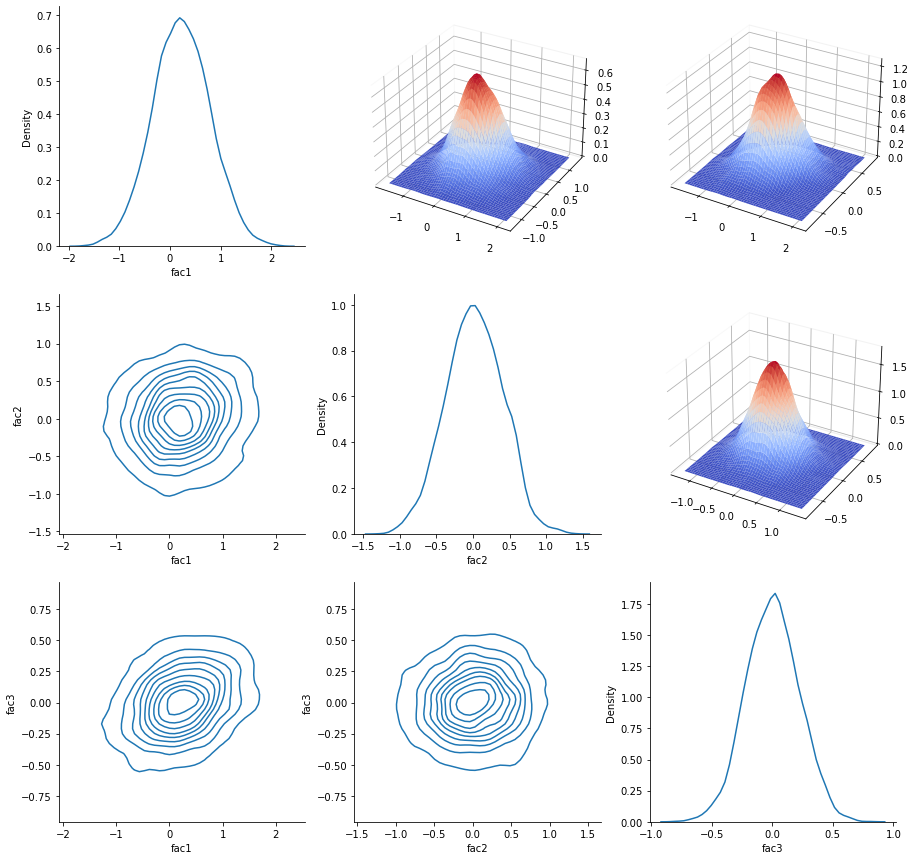

In [4]:
fig = plot_factor_distributions(
    states=filtered_states,
    model_dict=model_dict,
    add_3d_plots=True,
    period=1,
)

## Optional arguments of the plotting function

- You can omit the 3d Plots in the upper triangle by leaving out `add_3d_plots=True`. 
- You can modify the trade-off between runtime and plot quality by setting `n_points`, i.e. the number of points per dimension to different values. Default is 50.
- You can return the individual plots instead of a grid by setting `combine_plots_in_grid=False`. In that case the function returns a dictionary with figures that you can save for later use. 
- You can manually tweek the ranges over which the distributions are plotted. For that, you need to specify the argument `state_ranges`. This is a dictionary. The keys are the names of the latent factors. The values are DataFrames with the columns "period", "minimum", "maximum". The state_ranges are used to define the axis limits of the plots.
- lower_kde_kws (dict): Keyword arguments for seaborn.kdeplot, used to generate the plots in the lower triangle of the grid, i.e. the two dimensional kdeplot for each factor pair.
- diag_kde_kws (dict): Keyword arguments for seaborn.kdeplot, used to generate the plots on the diagonal of the grid, i.e. the one dimensional kdeplot for each factor. 
- surface_kws (dict): Keyword arguments for Axes.plot_surface, used to generate the plots in the upper triangle of the grid, i.e. the surface plot of the kernel density estimates for each factor pair.

## Getting simulated datasets (with and without policy)

One of the main application of skill formation models is to simulate the effect of counterfactual policies. To visualize the effect of a policy on factor distributions, we first need to simulate a dataset in which a policy has been active. 

In [5]:
with open(TEST_DIR/"model2.yaml") as y:
        model_dict = yaml.load(y, Loader=yaml.FullLoader)

params = pd.read_csv(TEST_DIR / "regression_vault" / f"one_stage_anchoring.csv")
params = params.set_index(["category", "period", "name1", "name2"])

In [6]:
control_means = pd.Series([0], index=["x1"])
control_sds = pd.Series([1], index=["x1"])

In [7]:
_, initial_data =simulate_dataset(model_dict, params, n_obs=100, control_means=control_means,
                             control_sds=control_sds, policies=None)

In [8]:
policies = [
        {"period": 1, "factor": "fac1", "effect_size": 3.5, "standard_deviation": 0.0},
        {"period": 1, "factor": "fac2", "effect_size": 3.5, "standard_deviation": 0.0}]

In [9]:
_, data_after_policies = simulate_dataset(model_dict, params, n_obs=100, control_means=control_means,
                             control_sds=control_sds, policies=policies)

## Plotting differences in distributions

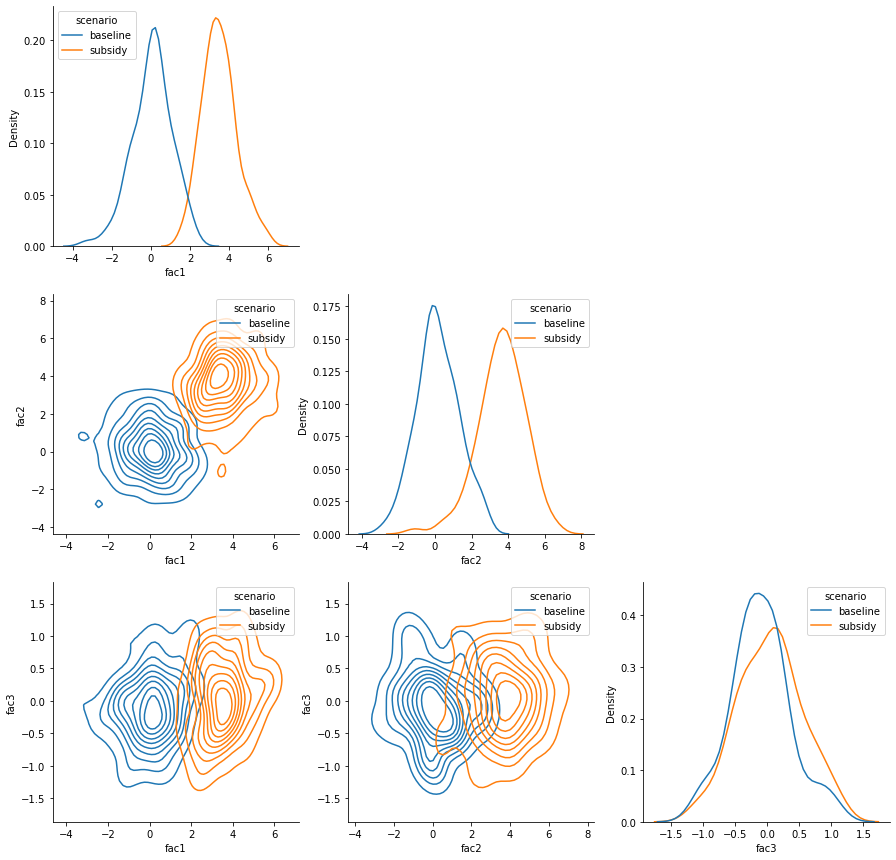

In [10]:
fig = plot_factor_distributions(
    states={"baseline": initial_data, "subsidy": data_after_policies}, 
    model_dict=model_dict,
    period=1,
)

All the optional arguments stay the same. The only difference ist that 3d plots do not work for several datasets.